# The Consumer Problem

**Table of contents**<a id='toc0_'></a>    
- 1. [Recap of optimization](#toc1_)    
  - 1.1. [Loops vs. optimizer](#toc1_1_)    
  - 1.2. [Gradient descent optimizer](#toc1_2_)    
- 2. [The consumer problem](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from types import SimpleNamespace # new? explained below
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Recap of optimization](#toc0_)

**The two most important tools:** 

1. Solving optimization problems with `scipy.optimize.minimize` and `scipy.optimize.minimize_scalar`
2. Solving equations with `scipy.optimize.root` and `scipy.optimize.root_scalar`

**Problem:** A bit of a black box. More details later in course.

**Now:** Compare with a) a *loop search* and b) a *hand-written optimizer*.

### 1.1. <a id='toc1_1_'></a>[Loops vs. scipy optimizer](#toc0_)

**Consider a simple maximization problem:** 

$$
\max_x f(x) = \max_x -3(x-2)^2+1
$$

**Solution:**

$$
f^\prime(x) = 0 \Leftrightarrow -6(x-2) = 0 \Leftrightarrow x = 2
$$

In [6]:
def f_func(x):
    return -3*(x-2)**2 + 1

**Rough solution with loop:**

In [7]:
N = 100
x_vec = np.linspace(-10,10,N)
f_vec = np.empty(N)

f_best = -np.inf # initial maximum
x_best = np.nan # not-a-number

for i,x in enumerate(x_vec):
    f_now = f_vec[i] = f_func(x)
    if f_now > f_best:
        x_best = x
        f_best = f_now

print(f'best with loop is {f_best:.8f} at x = {x_best:.8f}')

best with loop is 0.98041016 at x = 1.91919192


**Question:** Not quite right, how to improve?

**Plot:**

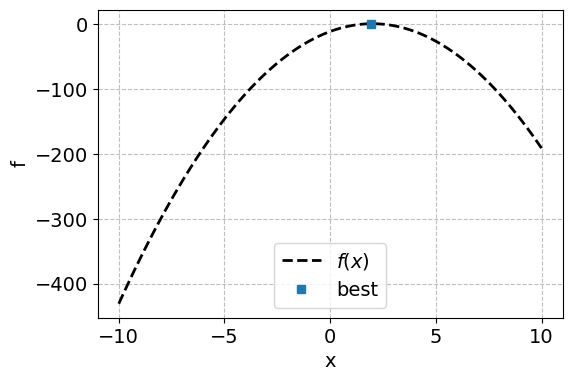

In [4]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(x_vec,f_vec,ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(x_best,f_best,ls='',marker='s',label='best')

ax.set_xlabel('x')
ax.set_ylabel('f')
ax.legend(loc='lower center',frameon=True);

**Solution with** `scipy.optimize.minimize_scalar` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar)):

In [5]:
obj = lambda x: -f_func(x) # here the input is a scalar
res = optimize.minimize_scalar(obj,bracket=(-10,10),method='brent')
x = res.x
f = -res.fun

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


**Solution with** `scipy.optimize.minimize` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)):

In [6]:
x_guess = [0]
obj = lambda x: -f_func(x[0]) # now the input is a vector
res = optimize.minimize(obj,x_guess,method='Nelder-Mead')
x = res.x[0]
f = -res.fun

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


**Solution with** `scipy.optimize.root_scalar` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html)):

Find derivative and solve via FOC:

In [7]:
def fp_func(x):
    return -6*(x-2)

In [8]:
obj = lambda x: fp_func(x) # here the input is a scalar
res = optimize.root_scalar(obj,bracket=(-10,10),method='bisect')
x = res.root
f = f_func(res.root)

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


**Solution with** `scipy.optimize.root` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html)):

In [9]:
x_guess = [0]    
obj = lambda x: fp_func(x[0]) # now the input is a vector
res = optimize.root(obj,x_guess,method='hybr')
x = res.x[0]
f = f_func(x)

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


### 1.2. <a id='toc1_2_'></a>[Handwritten optimizer](#toc0_)

**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, step size $\alpha > 0$, and guess on $x_0$, set $n=0$.
2. Compute  $f(x_n)$ and $f^\prime(x_n) \approx \frac{f(x_n+\Delta)-f(x_n)}{\Delta}$.
3. If $|f^\prime(x_n)| < \epsilon$ then stop.
4. Compute new guess "down the hill":

  $$
  x_{n+1} = x_{n} - \alpha f^\prime(x_n)
  $$


5. Set $n = n + 1$ and return to step 2.

**Code for algorithm:**

In [2]:
def gradient_descent(f,x0,alpha=0.5,Delta=1e-8,max_iter=500,eps=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (float): initial value
        alpha (float,optional): step size factor in search
        Delta (float,optional): step size in numerical derivative
        max_iter (int,optional): maximum number of iterations
        eps (float,optional): tolerance
        
    Returns:
    
        x (float): minimum
        fx (float): function value at minimum
        trials (list): og dicts with keys x, value and derivative
        
    """
    
    # step 1: initialize
    x = x0
    n = 0
    trials = []
    
    # step 2-4:
    while n < max_iter:
            
        # step 2: compute function value and derivative
        fx = f(x)
        fp = (f(x+Delta)-fx)/Delta
        
        trials.append({'x':x,'fx':fx,'fp':fp}) 
        
        # step 3: check convergence
        print(f'n = {n:3d}: x = {x:12.8f}, f = {fx:12.8f}, fp = {fp:12.8f}')
        if np.abs(fp) < eps:
            break
                  
        # step 4: update x
        x -= alpha*fp
        
        # step 5: update n
        n += 1
        
    return x,fx,trials

**New example:**

$$
\min_x f(x) = \min_x -\sin(x)+0.05x^2
$$

**Call the optimizer:**

In [3]:
x0 = -5
f = lambda x: -np.sin(x)+0.05*x**2

x,fx,trials = gradient_descent(f,x0)

print(f'\n best with gradient_descent is {fx:.8f} at x = {x:.8f}')

n =   0: x =  -5.00000000, f =   0.29107573, fp =  -0.78366216
n =   1: x =  -4.60816892, f =   0.06718704, fp =  -0.35678538
n =   2: x =  -4.42977623, f =   0.02081576, fp =  -0.16411191
n =   3: x =  -4.34772028, f =   0.01089161, fp =  -0.07813221
n =   4: x =  -4.30865417, f =   0.00862487, fp =  -0.03800982
n =   5: x =  -4.28964926, f =   0.00808617, fp =  -0.01870439
n =   6: x =  -4.28029706, f =   0.00795545, fp =  -0.00925834
n =   7: x =  -4.27566789, f =   0.00792338, fp =  -0.00459620
n =   8: x =  -4.27336979, f =   0.00791547, fp =  -0.00228511
n =   9: x =  -4.27222724, f =   0.00791352, fp =  -0.00113691
n =  10: x =  -4.27165878, f =   0.00791304, fp =  -0.00056587
n =  11: x =  -4.27137585, f =   0.00791292, fp =  -0.00028169
n =  12: x =  -4.27123501, f =   0.00791289, fp =  -0.00014025
n =  13: x =  -4.27116488, f =   0.00791288, fp =  -0.00006983
n =  14: x =  -4.27112996, f =   0.00791288, fp =  -0.00003476
n =  15: x =  -4.27111258, f =   0.00791288, fp =  -0.0

**Illusstration:**

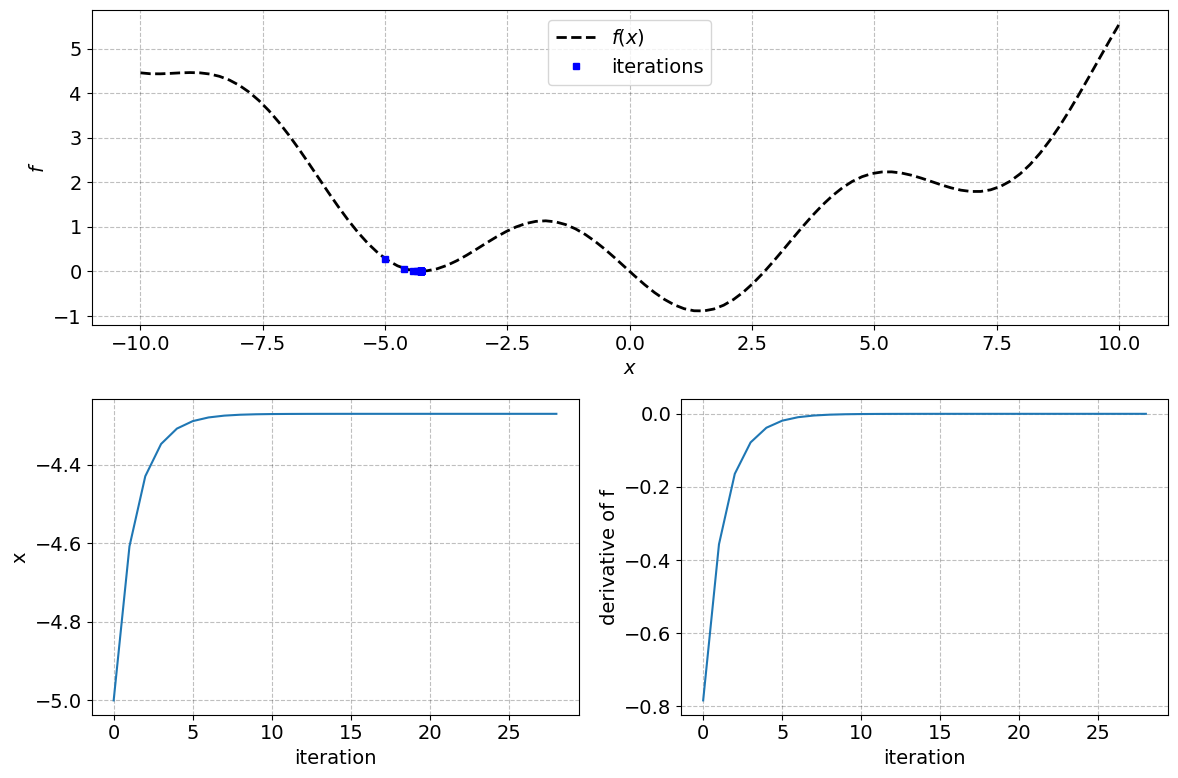

In [8]:
fig = plt.figure(figsize=(12,8))

# a. main figure
ax = fig.add_subplot(2,2,(1,2))

trial_x_vec = [trial['x'] for trial in trials]
trial_f_vec = [trial['fx'] for trial in trials]
trial_fp_vec = [trial['fp'] for trial in trials]

ax.plot(x_vec,f(x_vec),ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(trial_x_vec,trial_f_vec,ls='',marker='s',ms=4,color='blue',label='iterations')

ax.set_xlabel('$x$')
ax.set_ylabel('$f$')
ax.legend(loc='upper center',frameon=True)

# sub figure 1
ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(len(trials)),trial_x_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('x')

# sub figure 2
ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(len(trials)),trial_fp_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('derivative of f')

fig.tight_layout()

**Question:** Can we guess on any initial value of $x_0$?

## 2. <a id='toc2_'></a>[The consumer problem](#toc0_)

$$
\begin{aligned}
V(p_{1},p_{2},m) & = \max_{x_{1},x_{2}} \left(\alpha^{\frac{1}{\sigma}}x_{1}^{\frac{\sigma-1}{\sigma}}+(1-\alpha)^{\frac{1}{\sigma}}x_{2}^{\frac{\sigma-1}{\sigma}}\right)^{\frac{\sigma}{\sigma-1}}\\
 \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq m,\,\,\,p_{1},p_{2},m>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

**Goal:** Create a model-class to solve this problem.

1. Let `model` be a class
1. Let `model.par` contain all parameters (e.g. `model.par.alpha`)
1. Let `model.sol` contain the solution (e.g. `model.sol.x1`)

**SimpleNamespace():** Like a dictionary, but e.g. `par.alpha` instead of `par['alpha']`.  

In [14]:
par = SimpleNamespace()
par.alpha = 0.5
par.sigma = 0.1

print(f'alpha = {par.alpha:6.3f}')
print(f'sigma = {par.sigma:6.3f}')

alpha =  0.500
sigma =  0.100


Can always be interfaced as a dictionary with `__dict__`:

In [15]:
for k,v in par.__dict__.items():
    print(f'{k:5s} = {v:6.3f}')

alpha =  0.500
sigma =  0.100


**Utility function:**

In [16]:
def u_func(model,x1,x2):
    
    par = model.par
    
    u_x1 = par.alpha**(1/par.sigma)*x1**((par.sigma-1)/par.sigma)
    u_x2 = (1-par.alpha)**(1/par.sigma)*x2**((par.sigma-1)/par.sigma)
    
    return (u_x1+u_x2)**(par.sigma/(par.sigma-1))

**Solution function:**

In [17]:
def solve(model):
    
    par = model.par
    sol = model.sol    
    
    # a. objective function (to minimize) 
    obj = lambda x: -model.u_func(x[0],x[1]) # minimize -> negative of utility
        
    # b. constraints and bounds
    budget_constraint = lambda x: par.m-par.p1*x[0]-par.p2*x[1] # violated if negative
    constraints = ({'type':'ineq','fun':budget_constraint})
    bounds = ((1e-8,par.m/par.p1-1e-8),(1e-8,par.m/par.p2-1e-8))
    
    # why all these 1e-8? To avoid ever having x1 = 0 or x2 = 0
    
    # c. call solver
    x0 = [(par.m/par.p1)/2,(par.m/par.p2)/2]
    result = optimize.minimize(obj,x0,method='SLSQP',bounds=bounds,constraints=constraints)
        
    # d. save
    sol.x1 = result.x[0]
    sol.x2 = result.x[1]
    sol.u = model.u_func(sol.x1,sol.x2)

**Create consumer class:**

In [18]:
class ConsumerClass:
    
    def __init__(self): 
        
        # this is called automatically when a consumer is created
        
        # a. parameters
        par = self.par = SimpleNamespace()
        par.alpha = 0.5
        par.sigma = 0.1
        par.p1 = 1
        par.p2 = 2
        par.m = 10

        # b. solution
        sol = self.sol = SimpleNamespace()
        sol.x1 = np.nan
        sol.x2 = np.nan
        sol.u = np.nan
        
    u_func = u_func
    solve = solve
    

**Solve consumer problem**:

In [19]:
jeppe = ConsumerClass() # calls __init__()
jeppe.solve()
print(f'(x1,x2) = ({jeppe.sol.x1:.3f},{jeppe.sol.x2:.3f}), u = {jeppe.sol.u:.3f}')

(x1,x2) = (3.489,3.256), u = 6.705


Easy to loop over:

In [20]:
for alpha in np.linspace(0.3,0.7,5):
    jeppe.par.alpha = alpha
    jeppe.solve()
    print(f'alpha = {alpha:.3f} -> (x1,x2) = ({jeppe.sol.x1:.3f},{jeppe.sol.x2:.3f}), u = {jeppe.sol.u:.3f}')

alpha = 0.300 -> (x1,x2) = (1.868,4.066), u = 5.906
alpha = 0.400 -> (x1,x2) = (2.632,3.684), u = 6.282
alpha = 0.500 -> (x1,x2) = (3.489,3.256), u = 6.705
alpha = 0.600 -> (x1,x2) = (4.456,2.772), u = 7.186
alpha = 0.700 -> (x1,x2) = (5.556,2.222), u = 7.737


**Task:** Create another consumer with parameters of your choice.

In [23]:
anders = ConsumerClass()
anders.par.alpha=0.4
anders.solve()
print(f'alpha = {anders.par.alpha:.3f} -> (x1,x2) = ({anders.sol.x1:.3f},{anders.sol.x2:.3f}), u = {anders.sol.u:.3f}')

alpha = 0.400 -> (x1,x2) = (2.632,3.684), u = 6.282
